In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as st

np.set_printoptions(linewidth=180)

In [3]:
dt = 0.05
tau = 1
sig = .05
# dX = -X/tau*dt + sig*dW
# dX = 1/tau*dt + sig*dW


T_max = 5
X = np.zeros((1,)) + 0
T = np.zeros((1,))
#k = 0
t = 0
seed = 5


In [4]:
%%time

np.random.seed(seed)
while t<T_max:
    t += dt
    X = np.append(X,(1-dt/tau)*X[-1]+sig*np.sqrt(dt)*np.random.randn())
    #X = np.append(y, y[-1]+ dt/tau +sig*np.random.randn())
    T = np.append(T,t)
    

CPU times: total: 0 ns
Wall time: 2 ms


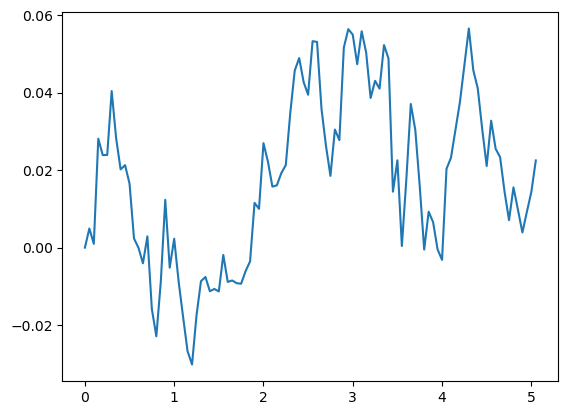

In [5]:
plt.plot(T,X)

$P_{t+1} = Q P_t$

$P(X_{t+1} \vert X_t)$

In [6]:
h = 0.005
X_states_space = np.arange(-0.1,0.1+h,h)
N = X_states_space.shape[0]
# approx 1
#diag = -sig**2/h**2 - np.abs(X_states_space)/h
#diag_inf = 0.5*sig**2/h**2 - np.maximum(X_states_space,0)/h
#diag_sup = 0.5*sig**2/h**2 - np.maximum(-X_states_space,0)/h

# approx 2
diag = -sig**2/h**2 + X_states_space*0 #- np.abs(X_states_space)/h
diag_inf = 0.5*sig**2/h**2 + X_states_space/tau/(2*h)
diag_sup = 0.5*sig**2/h**2 - X_states_space/tau/(2*h)


#h = 0.5*h
# approx 2
# diag = -sig**2/h**2 + X_states_space*0 #- np.abs(X_states_space)/h
# diag_inf = 0.5*sig**2/h**2 - 1/tau/(2*h) + X_states_space*0
# diag_sup = 0.5*sig**2/h**2 + 1/tau/(2*h) + X_states_space*0

Q = np.diag(diag)
Q += np.diag(diag_sup[:-1],1)
Q += np.diag(diag_inf[1:],-1)

Q[0,-1] = diag_inf[0]
Q[-1,0] = diag_sup[-1]

In [7]:
print(dt )
print(h**2)
print(sig)

#print(dt/h)

0.05
2.5e-05
0.05


In [8]:
M = np.zeros((N,1))
M[(N-1)//2] = 1
#M[6] = 1
X_markov_state = np.zeros((N,1))
X_markov_state[(N-1)//2] = 1
#X_markov_state[6] = 1

T = np.zeros((1,))
X = np.zeros((1,)) + 0
X_markov = np.zeros((1,)) + X[0]

exp_dtQ = linalg.expm(dt*Q).T

N_rep = 1000

In [9]:
np.random.seed(seed)

N_T = np.int32(T_max/dt)+2

X_markov_all = np.zeros((N_rep,N_T))
X_sde_all = np.zeros((N_rep,N_T))

for rep in range(N_rep):
    t = 0

    M = np.zeros((N,1))
    M[(N-1)//2] = 1
    X_markov_state = np.zeros((N,1))
    X_markov_state[(N-1)//2] = 1
    T = np.zeros((1,))
    X = np.zeros((1,)) + 0
    X_markov = np.zeros((1,)) + X[0]
    while t<T_max:
        t += dt

        rdm_num = np.random.randn()

        # Markov chain
        M_ = exp_dtQ@X_markov_state[:,-1]
        M = np.append(M,M_[:,np.newaxis], axis=-1)

        draw_unif = st.norm.cdf(rdm_num)
        draw_states = np.cumsum(draw_unif<np.cumsum(M_))==1
        X_markov_state = np.append(X_markov_state,draw_states[:,np.newaxis], axis=-1)
        X_markov = np.append(X_markov,X_states_space[np.bool_(draw_states)])

        # SDE
        X = np.append(X,(1-dt/tau)*X[-1]+sig*np.sqrt(dt)*rdm_num)
        T = np.append(T,t)
    
    X_markov_all[rep] = X_markov
    X_sde_all[rep] = X

In [12]:
# pdf_gauss = st.norm.pdf(X_states_space, scale=sig*np.sqrt(dt))*h
# plt.plot(X_states_space, pdf_gauss)
# plt.plot(X_states_space,M_)
#plt.plot(X_states_space,np.cumsum(M_))/pdf_gauss.max()/np.max(M_)

In [13]:
# plt.imshow(M, origin='lower')

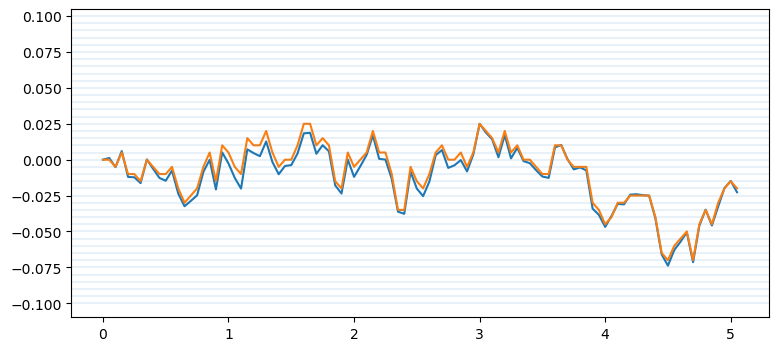

In [14]:
fig, ax = plt.subplots(1,1,figsize=(9,4))

ax.plot(T,X)
ax.plot(T,X_markov)

for i in range(N):
    ax.axhline(X_states_space[i], alpha=0.1)
#plt.plot(T,X_markov*5)

#ax.set_ylim(-0.05,0.07)

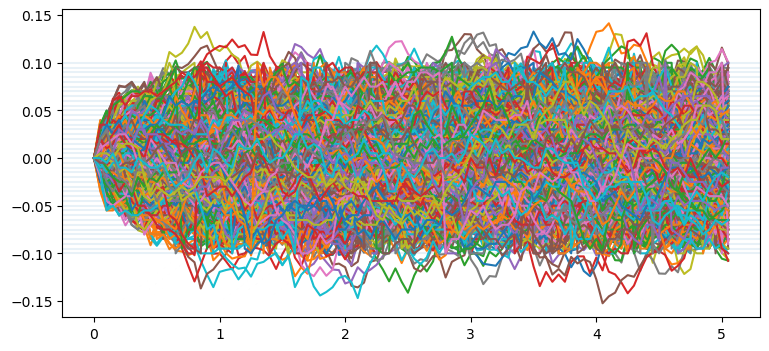

In [16]:
fig, ax = plt.subplots(1,1,figsize=(9,4))

ax.plot(T,X_sde_all[:].T)
ax.plot(T,X_markov_all[:].T)

for i in range(N):
    ax.axhline(X_states_space[i], alpha=0.1)
#plt.plot(T,X_markov*5)

#ax.set_ylim(-0.05,0.07)

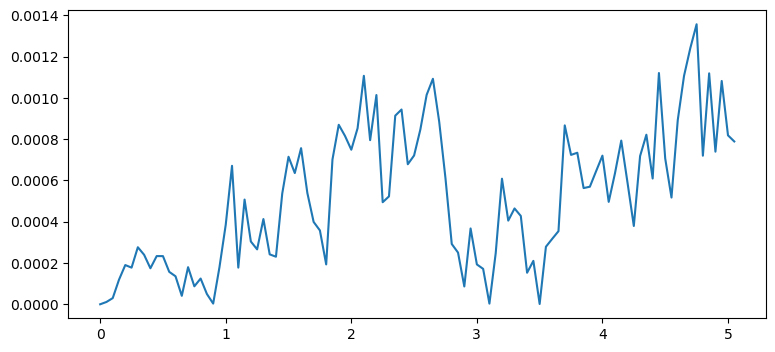

In [23]:
fig, ax = plt.subplots(1,1,figsize=(9,4))

ax.plot(T,np.abs(np.mean(X_sde_all-X_markov_all,axis=0)))

#ax.set_ylim(-0.05,0.07)

In [48]:
linalg.expm(dt*Q)[8,:]

array([1.25379566e-04, 5.46420765e-04, 2.06097680e-03, 6.76417193e-03, 1.90623883e-02, 4.53573155e-02, 8.93704605e-02, 1.42819499e-01, 1.81720980e-01, 1.82557453e-01,
       1.46154211e-01, 9.50491499e-02, 5.12889081e-02, 2.34200171e-02, 9.20579850e-03, 3.16033331e-03, 9.59164892e-04, 2.60019350e-04, 6.35119295e-05, 1.40823569e-05,
       2.85264759e-06, 5.30866980e-07, 9.11997999e-08, 1.45252306e-08, 2.15282622e-09, 2.97924265e-10, 3.86117119e-11, 4.70390410e-12, 5.79604190e-13, 3.80675262e-13,
       2.38385039e-12, 1.65297766e-11, 1.08053190e-10, 6.62467562e-10, 3.79762558e-09, 2.02862509e-08, 1.00593827e-07, 4.61042301e-07, 1.94343710e-06, 7.49219022e-06,
       2.62437579e-05])

In [49]:
M[:,1]

array([4.80267444e-14, 4.42561839e-13, 4.16487578e-12, 3.67923172e-11, 3.03941225e-10, 2.34104893e-09, 1.67564752e-08, 1.11042128e-07, 6.78411987e-07, 3.80288577e-06,
       1.94516227e-05, 9.02115625e-05, 3.76553261e-04, 1.40247851e-03, 4.61371196e-03, 1.32450385e-02, 3.27111283e-02, 6.83388693e-02, 1.18463820e-01, 1.66908136e-01,
       1.87651978e-01, 1.66908136e-01, 1.18463820e-01, 6.83388693e-02, 3.27111283e-02, 1.32450385e-02, 4.61371196e-03, 1.40247851e-03, 3.76553261e-04, 9.02115625e-05,
       1.94516227e-05, 3.80288577e-06, 6.78411987e-07, 1.11042128e-07, 1.67564752e-08, 2.34104893e-09, 3.03941225e-10, 3.67923172e-11, 4.16487578e-12, 4.42561839e-13,
       4.80267444e-14])

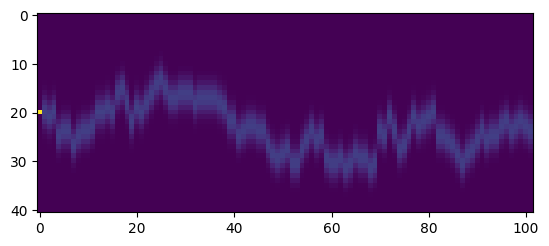

In [50]:
plt.imshow(M)

In [53]:
M.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [54]:
X_approx = np.copy(X)

for i in range(N):
    X_approx[(X_states_space[i+1]>X_approx)*(X_states_space[i]<X_approx)] = 0.5*(X_states_space[i]+X_states_space[i+1])

IndexError: index 41 is out of bounds for axis 0 with size 41

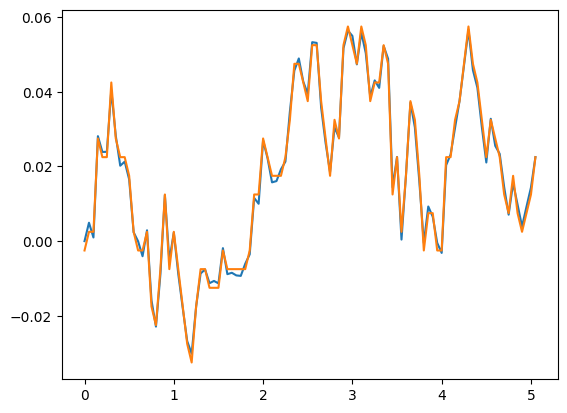

In [55]:
plt.plot(T,X)
plt.plot(T,X_approx)

In [30]:
# tab = np.array([[1,1,1,1,1,1,1,1,1,1],
#        [0,9,8,7,6,5,4,3,2,1],
#        [0,0,72,56,42,30,20,12,6,2],
#        [0,0,0,504,336,210,120,60,24,6],
#        [0,0,0,0,3024,1680,840,360,120,24]
#        ])
import sympy as sp

# Define the variables
a, b, c, d, e, f, g, h, i, j = sp.symbols('a b c d e f g h i j')
x, y = sp.symbols('x y')


# solution : collé a l'indentité en x, collé à la fonction zero en y, dérivable 4 fois
# Define the equations
eq1 = a*x**9 + b*x**8 + c*x**7 + d*x**6 + e*x**5 + f*x**4 + g*x**3 + h*x**2 + (i-1)*x + j
eq2 = 9*a*x**8 + 8*b*x**7 + 7*c*x**6 + 6*d*x**5 + 5*e*x**4 + 4*f*x**3 + 3*g*x**2 + 2*h*x + i - 1
eq3 = 72*a*x**7 + 56*b*x**6 + 42*c*x**5 + 30*d*x**4 + 20*e*x**3 + 12*f*x**2 + 5*g*x + 2*h
eq4 = 504*a*x**6 + 336*b*x**5 + 210*c*x**4 + 120*d*x**3 + 60*e*x**2 + 24*f*x + 6*g
eq5 = 3024*a*x**5 + 1680*b*x**4 + 840*c*x**3 + 360*d*x**2 + 120*e*x + 24*f

eq6 = a*y**9 + b*y**8 + c*y**7 + d*y**6 + e*y**5 + f*y**4 + g*y**3 + h*y**2 + i*y + j
eq7 = 9*a*y**8 + 8*b*y**7 + 7*c*y**6 + 6*d*y**5 + 5*e*y**4 + 4*f*y**3 + 3*g*y**2 + 2*h*y + i
eq8 = 72*a*y**7 + 56*b*y**6 + 42*c*y**5 + 30*d*y**4 + 20*e*y**3 + 12*f*y**2 + 5*g*y + 2*h
eq9 = 504*a*y**6 + 336*b*y**5 + 210*c*y**4 + 120*d*y**3 + 60*e*y**2 + 24*f*y + 6*g
eq10 = 3024*a*y**5 + 1680*b*y**4 + 840*c*y**3 + 360*d*y**2 + 120*e*y + 24*f

# Solve the system of equations
solution = sp.solve((eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9, eq10), (a, b, c, d, e, f, g, h, i, j))

print(solution)

print(solution[a].subs([(x,0.5),(y,0.6)]))

{a: (35*x**7 - 175*x**6*y + 1890*x**5*y**2 + 3150*x**4*y**3 + 3150*x**3*y**4 + 1890*x**2*y**5 - 175*x*y**6 + 35*y**7)/(x**15 - 15*x**14*y + 210*x**12*y**3 - 3318*x**10*y**5 + 11515*x**9*y**6 - 19665*x**8*y**7 + 19665*x**7*y**8 - 11515*x**6*y**9 + 3318*x**5*y**10 - 210*x**3*y**12 + 15*x*y**14 - y**15), b: (-160*x**8 + 650*x**7*y - 6650*x**6*y**2 - 18690*x**5*y**3 - 23800*x**4*y**4 - 18690*x**3*y**5 - 6650*x**2*y**6 + 650*x*y**7 - 160*y**8)/(x**15 - 15*x**14*y + 210*x**12*y**3 - 3318*x**10*y**5 + 11515*x**9*y**6 - 19665*x**8*y**7 + 19665*x**7*y**8 - 11515*x**6*y**9 + 3318*x**5*y**10 - 210*x**3*y**12 + 15*x*y**14 - y**15), c: (280*x**9 - 700*x**8*y + 7000*x**7*y**2 + 41720*x**6*y**3 + 69300*x**5*y**4 + 69300*x**4*y**5 + 41720*x**3*y**6 + 7000*x**2*y**7 - 700*x*y**8 + 280*y**9)/(x**15 - 15*x**14*y + 210*x**12*y**3 - 3318*x**10*y**5 + 11515*x**9*y**6 - 19665*x**8*y**7 + 19665*x**7*y**8 - 11515*x**6*y**9 + 3318*x**5*y**10 - 210*x**3*y**12 + 15*x*y**14 - y**15), d: (-224*x**10 - 140*x**9*y - 

In [33]:
alpha = 0.5
beta = 1.0

a_d = solution[a].subs([(x,alpha),(y,beta)])
b_d = solution[b].subs([(x,alpha),(y,beta)])
c_d = solution[c].subs([(x,alpha),(y,beta)])
d_d = solution[d].subs([(x,alpha),(y,beta)])
e_d = solution[e].subs([(x,alpha),(y,beta)])
f_d = solution[f].subs([(x,alpha),(y,beta)])
g_d = solution[g].subs([(x,alpha),(y,beta)])
h_d = solution[h].subs([(x,alpha),(y,beta)])
i_d = solution[i].subs([(x,alpha),(y,beta)])
j_d = solution[j].subs([(x,alpha),(y,beta)])

a_g = solution[a].subs([(x,-alpha),(y,-beta)])
b_g = solution[b].subs([(x,-alpha),(y,-beta)])
c_g = solution[c].subs([(x,-alpha),(y,-beta)])
d_g = solution[d].subs([(x,-alpha),(y,-beta)])
e_g = solution[e].subs([(x,-alpha),(y,-beta)])
f_g = solution[f].subs([(x,-alpha),(y,-beta)])
g_g = solution[g].subs([(x,-alpha),(y,-beta)])
h_g = solution[h].subs([(x,-alpha),(y,-beta)])
i_g = solution[i].subs([(x,-alpha),(y,-beta)])
j_g = solution[j].subs([(x,-alpha),(y,-beta)])


def fp(x):
    # f = np.zeros_like(x)

    # x_ = x[(x>-beta)*(x<=-alpha)]
    # f[(x>-beta)*(x<=-alpha)] = a_g*x_**9 + b_g*x_**8 + c_g*x_**7 + d_g*x_**6 + e_g*x_**5 + f_g*x_**4 + g_g*x_**3 + h_g*x_**2 + i_g*x_ + j_g

    # x_ = x[(x>-beta)*(x<=-alpha)]

    if x <= -beta :
        return 0
    if -beta <= x <= -alpha:
        return a_g*x**9 + b_g*x**8 + c_g*x**7 + d_g*x**6 + e_g*x**5 + f_g*x**4 + g_g*x**3 + h_g*x**2 + i_g*x + j_g
    if -alpha <= x <= alpha:
        return x
    if alpha <= x <= beta:
        return a_d*x**9 + b_d*x**8 + c_d*x**7 + d_d*x**6 + e_d*x**5 + f_d*x**4 + g_d*x**3 + h_d*x**2 + i_d*x + j_d
    if beta <= x :
        return 0
    


KeyError: 999

0.594929677904361


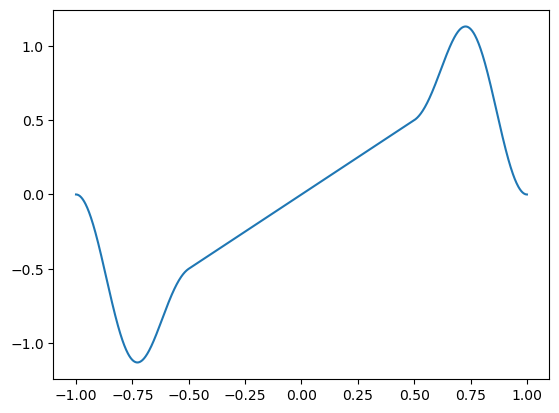

In [34]:

print(fp(0.55))

xx = np.linspace(-1, 1, 1000)
pfxx = np.empty(np.shape(xx))
for i,v in enumerate(xx):
    pfxx[i] = fp(v)


plt.plot(xx,pfxx)
plt.show()

# plt.plot(X_states_space,fp(X_states_space,0.5,0.6))







In [58]:
def heaviside(x,a):

    h = np.zeros_like(x)
    h[(x>-a)*(x<a)] = 1
    return h

C:\Users\vache\AppData\Local\Temp\ipykernel_25564\2762274495.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xx,xx*np.exp(1-1/(1-(xx/1)**10)))


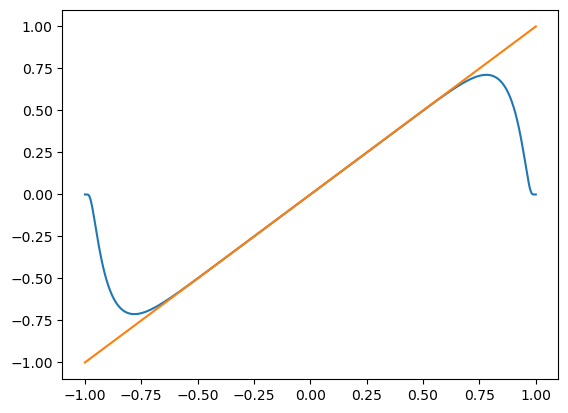

In [66]:
xx = np.linspace(-1, 1, 1000)
pfxx = np.empty(np.shape(xx))

#plt.plot(xx,np.exp(-1/(1-(xx/1)**10)))
plt.plot(xx,xx*np.exp(1-1/(1-(xx/1)**10)))
plt.plot(xx,xx)
#plt.plot(xx,heaviside(xx,0.5))
#plt.plot(xx,np.exp(1)*2*xx/(1-xx**2)**2*np.exp(-1/(1-xx**2)))

C:\Users\vache\AppData\Local\Temp\ipykernel_25564\1663892605.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(xx,np.abs(xx*(1-np.exp(1-1/(1-(xx/1)**10)))))


(0.0, 0.001)

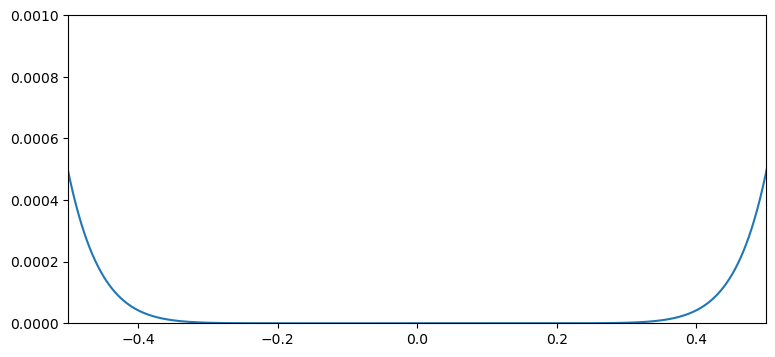

In [72]:

fig, ax = plt.subplots(1,1,figsize=(9,4))


ax.plot(xx,np.abs(xx*(1-np.exp(1-1/(1-(xx/1)**10)))))

ax.set_xlim(-0.5,0.5)
ax.set_ylim(0,1e-3)